In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import lines as mlines
import os
from astropy.table import Table

In [2]:
from read_sfh import get_scales
small_file_fname = "/Users/aphearin/Dropbox/UniverseMachine/data/histories/small_sfh_catalog_1.002310.txt"
scale_factor_array = get_scales(small_file_fname)

In [3]:
from assemble_catalog import assemble_catalog as assemble_history_data

snapshot_root_dirname = "/Users/aphearin/Dropbox/UniverseMachine/data/binary_reductions/z0/binaries/"
num_subvols = 144
history_cols = ('halo_id', 'halo_upid', 'halo_mpeak', 'halo_vmax_at_mpeak', 'halo_tidal_force', 
                'stellar_mass', 'sfr', 'sfr_mp', 'sm_mp')
history_data = Table(assemble_history_data(snapshot_root_dirname, num_subvols, *history_cols))

history_data['ssfr'] = history_data['sfr']/history_data['stellar_mass']
history_data['is_quenched'] = history_data['ssfr'] < 10**-11

In [10]:
from halocat_binary_reduction import assemble_halocat, read_column_info_array

halocat_binary_dirname = "/Users/aphearin/Dropbox/UniverseMachine/data/halocat_snapshot/a_1.00231"
column_info_fname = os.path.join(os.path.dirname(halocat_binary_dirname), 'column_info.dat')
column_info_array = read_column_info_array(column_info_fname)
propnames = ('halo_id', 'first_acc_scale', 'acc_rate_1tdyn', 'mpeak_scale', 'delta_vmax_tdyn_behroozi16', 
            'x', 'y', 'z', 'vx', 'vy', 'vz', 'mpeak')
halo_table = Table(assemble_halocat(halocat_binary_dirname, column_info_array, *propnames))
print("Available columns = \n{0}\n".format(halo_table.keys()))
print("number of halos in snapshot = {0}".format(len(halo_table)))

Available columns = 
['halo_id', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'mpeak', 'acc_rate_1tdyn', 'mpeak_scale', 'first_acc_scale', 'delta_vmax_tdyn_behroozi16']

number of halos in snapshot = 12085858


In [11]:
from halotools.utils import crossmatch
idxA, idxB = crossmatch(history_data['halo_id'].data, halo_table['halo_id'].data)
cat = history_data[idxA]

keys_to_add = ('x', 'y', 'z', 'vx', 'vy', 'vz', 
               'first_acc_scale', 'acc_rate_1tdyn', 'mpeak_scale', 
               'delta_vmax_tdyn_behroozi16', 'mpeak')
for key in keys_to_add:
    cat[key] = halo_table[key][idxB]

In [7]:
print("Percentage of histories with unmatched halos = {0:.3f}".format(
        len(history_data[idxA])/float(len(history_data))))

Percentage of histories with unmatched halos = 0.922


In [ ]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression()

In [ ]:
low_logsm, high_logsm = 10, 10.1
sample_mask = (cat['stellar_mass'] > 10**low_logsm) & (cat['stellar_mass'] < 10**high_logsm)
sample = cat[sample_mask]

In [ ]:
features = ('halo_delta_vmax_behroozi17', )
n_samples, n_features = len(sample), len(features)

X = np.zeros((n_samples, n_features))
for i, feature in enumerate(features):
    X[:, 0] = sample[feature]
y = sample['is_quenched'].data

In [ ]:
logit = logit.fit(X, y)

In [ ]:
plt.scatter(sample['halo_delta_vmax_behroozi17'], sample['is_quenched'])

In [ ]:
guess, confidence = logit.predict(X), logit.decision_function(X)

In [ ]:
np.mean(guess == y)

In [ ]:
confidence[0:10]

In [ ]:
__ = plt.hist(confidence, bins = np.linspace(-5, 5, 100))

In [12]:
cat.keys()

['halo_id',
 'halo_upid',
 'halo_vmax_at_mpeak',
 'sfr_mp',
 'sfr',
 'halo_tidal_force',
 'halo_mpeak',
 'sm_mp',
 'stellar_mass',
 'ssfr',
 'is_quenched',
 'x',
 'y',
 'z',
 'vx',
 'vy',
 'vz',
 'first_acc_scale',
 'acc_rate_1tdyn',
 'mpeak_scale',
 'delta_vmax_tdyn_behroozi16',
 'mpeak']

In [15]:
diff = cat['mpeak'] - cat['halo_mpeak']
fracdiff = diff/cat['halo_mpeak']

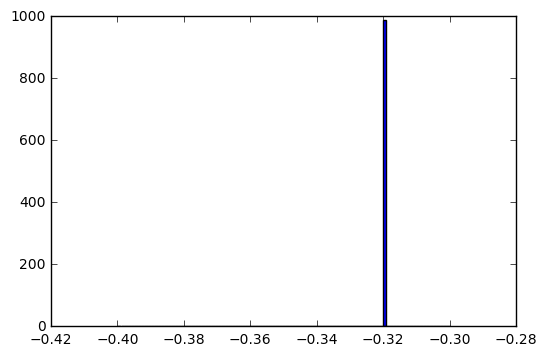

In [22]:
__ = plt.hist(fracdiff, bins=np.linspace(-0.4, -0.3, 100), normed=True)

In [20]:
fracdiff.max()

1.471732